 # Feature Store Tour - Python API
 
This notebook contains a tour/reference for the feature store Python API on hopsworks. The notebook is ment to be run from feature store demo projects on Hopsworks. We will go over best practices for using the API as well as common pitfalls.
 
The notebook is designed to be used in combination with the Feature Store Tour on Hopsworks, it assumes that you have run the following feature engineering job: [job](https://github.com/logicalclocks/hops-examples/tree/master/featurestore) (**the job is added automatically when you start the feature store tour in Hopsworks. You can run the job by going to the 'Jobs' tab to the left in the Hopsworks project home page**). 

Which will produce the following model of feature groups in your project's feature store:

![Feature Store Model](./images/model.png "Feature Store Model")

In this notebook we will run queries over this feature store model. We will also create new feature groups and training datasets.

We will go from (1) features to (2) training datasets to (3) A trained model

## Feature Store 101

The simplest way to think about the feature store is as a central place to store curated /features/ within an organization. A feature is a measurable property of some phenomenon. It could be for example an image-pixel, a word from a piece of text, the age of a person, a coordinate emitted from a sensor, or an aggregate value like the average number of purchases within the last hour.

A feature store is a data management layer for machine learning that can optimize the machine learning workflow and provide an interface between data engineering and data science.

![Feature Store Overview](./images/overview.png "Feature Store Overview")

A feature store is not a pure storage service, it goes hand-in-hand with feature computation. Feature engineering is the process of transforming raw data into a format that is compatible and understandable for predictive models.

There are two interfaces to the feature store:

- Writing to the feature store, at the end of the feature engineering pipeline the features are written to the feature store, e.g:
```python
raw_data = spark.read.format("csv").load(filename)
polynomial_features = raw_data.map(lambda x: x^2)
from hops import featurestore
featurestore.insert_into_featuregroup(polynomial_features, "polynomial_features")
```
- Reading from the feature store, to train a model on a set of features, the features can be read from the feature store, e.g:
```python
from hops import featurestore
features_df = featurestore.get_features(["team_budget", "average_attendance", "average_player_age"])
```

As a data engineer/data scientist, you can think of the feature store as a middle-layer. Once you have computed a set of features, instead of writing them locally to a csv file, insert them in the feature store so that the features can get documented/versioned, backfilled, **and so that your colleagues can re-use your features!** 

## Imports

The hops library is automatically installed in all Hopsworks-projects. This library has a module called `featurestore` that provides an API for the feature store. You can find API documentation [here](http://hops-py.logicalclocks.com/).

In [1]:
from hops import featurestore

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
21,application_1549990428861_0023,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


## Get The Name of The Project's Feature Store

Each project with the feature store service enabled automatically gets its own feature store created. This feature store is only accessible within the project unless you decide to share it with other projects. The name of the feature store is `<project_name>_featurestore`, and you can get the name with the API method `project_featurestore()`. 

In [2]:
featurestore.project_featurestore()

'demo_featurestore_admin000_featurestore'

## Get a List of All Feature Stores Accessible in the Current Project 

Feature Stores can be shared across projects in a multi-tenant manner, just like any Hopsworks-dataset can. You can read more about sharing datasets at [hops.io](hops.io), but in essence to share a dataset you just have to right click on it in your project. The feature groups in the feature store are located in a dataset called `<project_name>_featurestore.db` in your project.

![Share Feature Store](./images/share_featurestore.png "Share Feature Store")

The Training Datasets in your feature store are located in a datased called `<project_name>_Training_Datasets` inside your project. Typically if you want to share a feature store with another project you will share both the `<project_name>_featurestore.db` dataset and the `<project_name>_Training_Datasets` dataset.

![Share Feature Store](./images/share_featurestore2.png "Share Feature Store")

To list all feature stores accessible in the current project, you can use the API method `get_project_featurestores()`. You can also view the list of accessible feature stores in the feature registry UI:

![Share Feature Store](./images/select_fs.png "Share Feature Store")

By using multiple feature stores and feature store sharing across projects you can enforce access rights to features.

![Multi-Tenant Feature Stores](./images/multitenant.png "Multi-Tenant Feature Stores")

In [3]:
featurestore.get_project_featurestores()

['demo_featurestore_admin000_featurestore']

## Querying The Feature Store

The feature store can be queried programmatically and with raw SQL. When you query the feature store programmatically, the library will infer how to fetch the different features using a **query planner**. 

![Feature Store Query Planner](./images/query_optimizer.png "Feature Store Query Planner")

When interacting with the feature store it is sufficient to be familiar with three concepts:

- The **feature**, this refer to an individual versioned and documented feature in the feature store, e.g the age of a person.
- The **feature group**, this refer to a documented and versioned group of features stored as a Hive table that is linked to a specific Spark/Numpy/Pandas job that takes in raw data and outputs the computed features.
- The **training dataset**, this refer to a versioned and managed dataset of features, stored in HopsFS as tfrecords, .csv, .tsv, or parquet.

A feature group contains a group of features and a training dataset contains a set of features, potentially from many different feature groups.

![Feature Store Concepts](./images/concepts.png "Feature Store Contents")

When you query the feature store you will always get back the results in a spark dataframe. This is for scalability reasons. If the dataset is small and you want to work with it in memory you can convert it into a pandas dataframe or a numpy matrix using one line of code as we will demonstrate later on in this notebook.

### Fetch an Individual Feature

When retrieving a single feature from the featurestore, the hops-util-py library will infer in which feature group the feature belongs to by querying the metastore, but you can also explicitly specify which featuregroup and version to query. 

If there are multiple features of the same name in the featurestore, it is required to specify enough information to uniquely identify the feature (e.g specify feature group and version). If no featurestore is provided it will default to the project's featurestore.

To read an individual feature, use the method `get_feature(feature_name)`

Without specifying the feature store, feature group and version, the library will infer it:

In [4]:
featurestore.get_feature("team_budget").show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT team_budget FROM teams_features_1
+-----------+
|team_budget|
+-----------+
|  12957.076|
|  2403.3704|
|  3390.3755|
|  13547.429|
|   9678.333|
+-----------+
only showing top 5 rows

You can also explicitly specify the feature store, feature group, the version, and the return format:

In [5]:
featurestore.get_feature(
    "team_budget", 
    featurestore=featurestore.project_featurestore(), 
    featuregroup="teams_features", 
    featuregroup_version = 1,
    dataframe_type = "spark"
).show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT team_budget FROM teams_features_1
+-----------+
|team_budget|
+-----------+
|  12957.076|
|  2403.3704|
|  3390.3755|
|  13547.429|
|   9678.333|
+-----------+
only showing top 5 rows

### Fetch an Entire Feature Group

You can get an entire featuregroup from the API. If no feature store is provided the API will default to the project's feature store, if no version is provided it will default to version 1 of the feature group. The default return format is as a spark dataframe.

In [6]:
featurestore.get_featuregroup("teams_features").show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT * FROM teams_features_1
+-----------+-------+-------------+
|team_budget|team_id|team_position|
+-----------+-------+-------------+
|  12957.076|      1|            1|
|  2403.3704|      2|            2|
|  3390.3755|      3|            3|
|  13547.429|      4|            4|
|   9678.333|      5|            5|
+-----------+-------+-------------+
only showing top 5 rows

The default parameters can be overriden:

In [7]:
featurestore.get_featuregroup(
    "teams_features", 
    featurestore=featurestore.project_featurestore(), 
    featuregroup_version = 1,
    dataframe_type = "spark"
).show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT * FROM teams_features_1
+-----------+-------+-------------+
|team_budget|team_id|team_position|
+-----------+-------+-------------+
|  12957.076|      1|            1|
|  2403.3704|      2|            2|
|  3390.3755|      3|            3|
|  13547.429|      4|            4|
|   9678.333|      5|            5|
+-----------+-------+-------------+
only showing top 5 rows

### Fetch A Set of Features

When retrieving a list of features from the featurestore, the hops-util-py library will infer which featuregroup the features belongs to by querying the metastore. If the features reside in different featuregroups, the library will also try to infer how to join the features together based on common columns. If the JOIN query cannot be inferred due to existence of multiple features with the same name or non-obvious JOIN query, the user need to supply enough information to the API call to be able to query the featurestore. If the user already knows the JOIN query it can also run featurestore.sql(joinQuery) directly (an example of this is shown further down in this notebook). If no featurestore is provided the API will default to the project's featurestore.

Example of querying the feature store for a list of features without specifying the feature groups and feature store:

In [8]:
featurestore.get_features(
    ["team_budget", "average_attendance", "average_player_age"]
).show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT average_player_age, team_budget, average_attendance FROM players_features_1 JOIN teams_features_1 JOIN attendances_features_1 ON players_features_1.`team_id`=teams_features_1.`team_id` AND players_features_1.`team_id`=attendances_features_1.`team_id`
+------------------+-----------+------------------+
|average_player_age|team_budget|average_attendance|
+------------------+-----------+------------------+
|             24.85|    7307.94|         19595.973|
|             25.45|   7326.092|          6462.462|
|              25.4|   3555.235|          7226.672|
|             25.91|  910.39325|         3189.8455|
|             25.78|  12474.419|          9405.213|
+------------------+-----------+------------------+
only showing top 5 rows

We can also explicitly specify the feature groups where the features reside. Either the feature groups and versions can be specified by prepending feature names with `<feature group name>_<feature group version.`, or by providing a dict with entries of `<feature group name> -> <feature group version>`:

In [9]:
featurestore.get_features(
    ["teams_features_1.team_budget", 
     "attendances_features_1.average_attendance", 
     "players_features_1.average_player_age"]
).show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT attendances_features_1.average_attendance, teams_features_1.team_budget, players_features_1.average_player_age FROM attendances_features_1 JOIN teams_features_1 JOIN players_features_1 ON attendances_features_1.`team_id`=teams_features_1.`team_id` AND attendances_features_1.`team_id`=players_features_1.`team_id`
+------------------+-----------+------------------+
|average_attendance|team_budget|average_player_age|
+------------------+-----------+------------------+
|          3271.934|  16758.066|             25.65|
|         4074.8047|  3966.3591|              25.5|
|         19595.973|    7307.94|             24.85|
|          6462.462|   7326.092|             25.45|
|          7226.672|   3555.235|              25.4|
+------------------+-----------+------------------+
only showing top 5 rows

In [10]:
featurestore.get_features(
    ["team_budget", "average_attendance", "average_player_age"],
    featurestore=featurestore.project_featurestore(),
    featuregroups_version_dict={
        "teams_features": 1, 
        "attendances_features": 1,
        "players_features": 1
    }
).show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT average_player_age, team_budget, average_attendance FROM teams_features_1 JOIN players_features_1 JOIN attendances_features_1 ON teams_features_1.`team_id`=players_features_1.`team_id` AND teams_features_1.`team_id`=attendances_features_1.`team_id`
+------------------+-----------+------------------+
|average_player_age|team_budget|average_attendance|
+------------------+-----------+------------------+
|             24.85|    7307.94|         19595.973|
|             25.45|   7326.092|          6462.462|
|              25.4|   3555.235|          7226.672|
|             25.91|  910.39325|         3189.8455|
|             25.78|  12474.419|          9405.213|
+------------------+-----------+------------------+
only showing top 5 rows

If you have a lot of name collisions and it is not obvious how to infer the JOIN query to get the features from the feature store. You can explicitly specify the argument `join_key` to the API (or you can provide the entire SQL query using the API method `.sql` as we will demonstrate later on in the notebook)

In [11]:
featurestore.get_features(
    ["team_budget", "average_attendance", "average_player_age"],
    featurestore=featurestore.project_featurestore(),
    featuregroups_version_dict={
        "teams_features": 1, 
        "attendances_features": 1,
        "players_features": 1
    },
    join_key = "team_id",
    dataframe_type = "spark"
).show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT average_player_age, team_budget, average_attendance FROM teams_features_1 JOIN attendances_features_1 JOIN players_features_1 ON teams_features_1.`team_id`=attendances_features_1.`team_id` AND teams_features_1.`team_id`=players_features_1.`team_id`
+------------------+-----------+------------------+
|average_player_age|team_budget|average_attendance|
+------------------+-----------+------------------+
|             25.65|  16758.066|          3271.934|
|              25.5|  3966.3591|         4074.8047|
|             24.85|    7307.94|         19595.973|
|             25.45|   7326.092|          6462.462|
|              25.4|   3555.235|          7226.672|
+------------------+-----------+------------------+
only showing top 5 rows

#### Advanced Eamples of Fetching Sets of Features and Common Pitfalls

Getting 12 features from 4 different feature groups:

In [12]:
featurestore.get_features(
    ["team_budget", "average_attendance", "average_player_age",
    "team_position", "sum_attendance", 
     "average_player_rating", "average_player_worth", "sum_player_age",
     "sum_player_rating", "sum_player_worth", "sum_position", 
     "average_position"
    ]
).show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT team_budget, average_position, sum_player_rating, average_attendance, average_player_worth, sum_player_worth, sum_position, sum_attendance, average_player_rating, team_position, sum_player_age, average_player_age FROM teams_features_1 JOIN season_scores_features_1 JOIN players_features_1 JOIN attendances_features_1 ON teams_features_1.`team_id`=season_scores_features_1.`team_id` AND teams_features_1.`team_id`=players_features_1.`team_id` AND teams_features_1.`team_id`=attendances_features_1.`team_id`
+-----------+----------------+-----------------+------------------+--------------------+----------------+------------+--------------+---------------------+-------------+--------------+------------------+
|team_budget|average_position|sum_player_rating|average_attendance|average_player_worth|sum_player_worth|sum_position|sum_attendance|average_player_rating|team_position|sum_player_age|average_player_age|
+--------

##### Example Errors

Lets look at an example of a common error that can occur when you query the feature store.

If you try to query the feature store for a feature that exists in multiple feature groups, it is impossible for the query planner to infer from which feature group to fetch the feature so it will throw an exception. When this error happen you should specify which feature group to fetch from so that the query planner knows how to get the feature.

**Note**: <font color='red'>This cell should fail, don't panic :)</font>

In [13]:
featurestore.get_features(
    ["team_budget", "team_id"]
).show(5)

Found the feature with name 'team_id' in more than one of the featuregroups of the featurestore: 'demo_featurestore_admin000_featurestore', please specify the optional argument 'featuregroup=', the matched featuregroups were: season_scores_features_1,teams_features_1,players_features_1,attendances_features_1
Traceback (most recent call last):
  File "/srv/hops/anaconda/anaconda/envs/demo_featurestore_admin000/lib/python3.6/site-packages/hops/featurestore.py", line 704, in get_features
    return _do_get_features(features, _get_featurestore_metadata(featurestore, update_cache=True), featurestore=featurestore, featuregroups_version_dict=featuregroups_version_dict, join_key=join_key, dataframe_type=dataframe_type)
  File "/srv/hops/anaconda/anaconda/envs/demo_featurestore_admin000/lib/python3.6/site-packages/hops/featurestore.py", line 781, in _do_get_features
    featuregroup_matched = _find_feature(feature, featurestore, featuregroups_parsed)
  File "/srv/hops/anaconda/anaconda/envs/dem

Let's fix the error: 

In [14]:
featurestore.get_features(
    ["team_budget", "team_id"],
    featuregroups_version_dict = {
        "teams_features" : 1
    }
).show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT team_budget, team_id FROM teams_features_1
+-----------+-------+
|team_budget|team_id|
+-----------+-------+
|  12957.076|      1|
|  2403.3704|      2|
|  3390.3755|      3|
|  13547.429|      4|
|   9678.333|      5|
+-----------+-------+
only showing top 5 rows

Another common error is that you try to fetch features from feature groups that are not compatible, they do not got any natural join column. Typically in this case you need to either provide the join key your self or use SQL directly with `featurestore.sql()`.


**Note**: <font color='red'>This cell should fail, don't panic :)</font>

In [15]:
featurestore.get_features(
    ["team_budget", "score"]
).show(5)

Could not find any common columns in featuregroups to join on, searched through featuregroups: teams_features, games_features
Traceback (most recent call last):
  File "/srv/hops/anaconda/anaconda/envs/demo_featurestore_admin000/lib/python3.6/site-packages/hops/featurestore.py", line 704, in get_features
    return _do_get_features(features, _get_featurestore_metadata(featurestore, update_cache=True), featurestore=featurestore, featuregroups_version_dict=featuregroups_version_dict, join_key=join_key, dataframe_type=dataframe_type)
  File "/srv/hops/anaconda/anaconda/envs/demo_featurestore_admin000/lib/python3.6/site-packages/hops/featurestore.py", line 794, in _do_get_features
    join_col = _get_join_col(feature_featuregroups)
  File "/srv/hops/anaconda/anaconda/envs/demo_featurestore_admin000/lib/python3.6/site-packages/hops/featurestore.py", line 650, in _get_join_col
    "{}".format(featuregroups_str))
AssertionError: Could not find any common columns in featuregroups to join on, s

Lets fix the error:

In [16]:
featurestore.sql(
    "SELECT team_budget, score " \
    "FROM teams_features_1 JOIN games_features_1 ON " \
    "games_features_1.home_team_id = teams_features_1.team_id").show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT team_budget, score FROM teams_features_1 JOIN games_features_1 ON games_features_1.home_team_id = teams_features_1.team_id
+-----------+-----+
|team_budget|score|
+-----------+-----+
|  11296.577|    1|
|   4969.735|    3|
|  21319.533|    2|
|  15072.062|    1|
|  12957.076|    3|
+-----------+-----+
only showing top 5 rows

### Free Text SQL Query from the Feature Store

For complex queries that cannot be inferred by the helper functions, enter the sql directly to the method `featurestore.sql()` it will default to the project specific feature store but you can also specify it explicitly. If you are proficient in SQL, this is the most efficient and preferred way to query the feature store.

Without specifying the feature store the query will by default be run against the project's feature store:

In [17]:
featurestore.sql("SELECT * FROM teams_features_1 WHERE team_position < 5").show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT * FROM teams_features_1 WHERE team_position < 5
+-----------+-------+-------------+
|team_budget|team_id|team_position|
+-----------+-------+-------------+
|  12957.076|      1|            1|
|  2403.3704|      2|            2|
|  3390.3755|      3|            3|
|  13547.429|      4|            4|
+-----------+-------+-------------+

You can also specify the featurestore to query and the return format explicitly:

In [18]:
featurestore.sql("SELECT * FROM teams_features_1 WHERE team_position < 5",
                featurestore=featurestore.project_featurestore(), 
                 dataframe_type = "spark").show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT * FROM teams_features_1 WHERE team_position < 5
+-----------+-------+-------------+
|team_budget|team_id|team_position|
+-----------+-------+-------------+
|  12957.076|      1|            1|
|  2403.3704|      2|            2|
|  3390.3755|      3|            3|
|  13547.429|      4|            4|
+-----------+-------+-------------+

## Writing to the Feature Store


### Creating New Feature Groups

In most cases it is recommended that feature groups are created in the UI on Hopsworks and that care is taken in documenting the feature group. 

![Create Feature Group from the UI](./images/create_fg.png "Create Feature Group from the UI")

![Create Feature Group from the UI](./images/create_fg_2.png "Create Feature Group from the UI")

However, sometimes it is practical to create a feature group directly from a spark dataframe and fill in the metadata about the featuregroup later in the UI. This can be done through the `create_featuregroup()` API function.

Lets create a new featuregroup called **teams_features_spanish** that contains the same contents as the feature group teams_features except the the columns are renamed to spanish

In [19]:
teams_features_1_df = featurestore.get_featuregroup("teams_features")

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT * FROM teams_features_1

In [20]:
teams_features_2_df = teams_features_1_df.withColumnRenamed(
    "team_id", "equipo_id").withColumnRenamed(
    "team_budget", "equipo_presupuesto").withColumnRenamed(
    "team_position", "equipo_posicion")

In [21]:
teams_features_2_df.show(5)

+------------------+---------+---------------+
|equipo_presupuesto|equipo_id|equipo_posicion|
+------------------+---------+---------------+
|         12957.076|        1|              1|
|         2403.3704|        2|              2|
|         3390.3755|        3|              3|
|         13547.429|        4|              4|
|          9678.333|        5|              5|
+------------------+---------+---------------+
only showing top 5 rows

Lets now create a new featuregroup using the transformed dataframe (we'll explain the statistics part later on in this notebook)

In [22]:
featurestore.create_featuregroup(
    teams_features_2_df,
    "teams_features_spanish",
    description="a spanish version of teams_features",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False
)

Running sql: use demo_featurestore_admin000_featurestore

By default the new featuregroup will be created in the project's featurestore and the statistics for the new featuregroup will be computed based on the provided spark dataframe. You can configure this behaviour by modifying the default arguments and filling in extra metadata.

The dependencies argument takes a list of HDFS file names that the feature group depends on, i.e when the datasets that a featuregroup depends on have been modified, the feature group should be recomputed. The dependencies can also be updated and viewed in the feature registry UI. 

![Feature group dependencies](./images/deps.png "Feature group dependencies")

![Feature group dependencies](./images/deps2.png "Feature group dependencies")

The jobId argument takes an integer that identifies the job id to compute the features. Once you have created a job that creates/inserts features in the feature store you can use the Featurestore UI to link that job to the featuregroup:

![Feature group jobs](./images/jobs1.png "Feature group jobs")

![Feature group jobs](./images/jobs2.png "Feature group jobs")

In [23]:
featurestore.create_featuregroup(
    teams_features_2_df,
    "teams_features_spanish",
    description="a spanish version of teams_features",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    featurestore=featurestore.project_featurestore(),
    featuregroup_version=1,
    job_name=None,
    dependencies=[]
)

Running sql: use demo_featurestore_admin000_featurestore

###  Create a New Version of A Feature Group

To create a new version, simply use the `create_featuregroup` method and specify the version argument:

In [24]:
featurestore.create_featuregroup(
    teams_features_2_df,
    "teams_features_spanish",
    description="a spanish version of teams_features",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    featuregroup_version=2
)

Running sql: use demo_featurestore_admin000_featurestore

You can now see the new version in the feature store UI:

![Create Feature Group Version](./images/create_fg_version.png "Create Feature Group Version")

#### Get the Latest Version of a Feature Group (0 if no version exist)

In [25]:
latest_version = featurestore.get_latest_featuregroup_version("teams_features_spanish")
latest_version

2

#### Update Metadata Cache

Note: By default, the python client will only fetch the featurestore metadata once and then cache it on the client. If you need to update the cache you can use the command:

In [27]:
featurestore.get_featurestore_metadata(update_cache=True)

### Inserting Into Existing Feature Groups

A best practice when working with features in HopsML is to first figure out a model of feature groups and create them  using the Feature Registry UI. This will prepare the feature group schema and create the Hive tables. Once the empty feature groups are created, then you can insert into these tables directly.

Lets first get some sample data to insert

In [28]:
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, LongType, IntegerType, FloatType
sqlContext = SQLContext(sc)

In [29]:
schema = StructType([StructField("equipo_id", IntegerType(), True),
                     StructField("equipo_presupuesto", FloatType(), True),
                     StructField("equipo_posicion", IntegerType(), True)
                        ])
sample_df = sqlContext.createDataFrame([(999, 41251.52, 1), (998, 1319.4, 8), (997, 21219.1, 2)], schema)

In [30]:
sample_df.show(5)

+---------+------------------+---------------+
|equipo_id|equipo_presupuesto|equipo_posicion|
+---------+------------------+---------------+
|      999|          41251.52|              1|
|      998|            1319.4|              8|
|      997|           21219.1|              2|
+---------+------------------+---------------+

In [31]:
sample_df.count()

3

Lets inspect the contents of the featuregroup `teams_features_spanish` that we are going to insert the sample data into:

In [32]:
spanish_team_features_df = featurestore.get_featuregroup(
    "teams_features_spanish")

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT * FROM teams_features_spanish_1

In [33]:
spanish_team_features_df.show(5)

+------------------+---------+---------------+
|equipo_presupuesto|equipo_id|equipo_posicion|
+------------------+---------+---------------+
|         12957.076|        1|              1|
|         2403.3704|        2|              2|
|         3390.3755|        3|              3|
|         13547.429|        4|              4|
|          9678.333|        5|              5|
+------------------+---------+---------------+
only showing top 5 rows

In [34]:
spanish_team_features_df.count()

50

Now we can insert the sample data and verify the new contents of the featuregroup. By default the insert mode is "append", the featurestore is the project's featurestore, the version is 1 and statistics will be updated (we cover statistics later on in this notebook).

In [35]:
featurestore.insert_into_featuregroup(
    sample_df, 
    "teams_features_spanish", 
    descriptive_statistics=False, 
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False
)

Running sql: use demo_featurestore_admin000_featurestore

Lets now inspect the contents of the feature group to verify that the insertion was successful

In [36]:
spanish_team_features_df_updated = featurestore.get_featuregroup(
    "teams_features_spanish")

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT * FROM teams_features_spanish_1

In [37]:
spanish_team_features_df_updated.show(5)

+------------------+---------+---------------+
|equipo_presupuesto|equipo_id|equipo_posicion|
+------------------+---------+---------------+
|         12957.076|        1|              1|
|         2403.3704|        2|              2|
|         3390.3755|        3|              3|
|         13547.429|        4|              4|
|          9678.333|        5|              5|
+------------------+---------+---------------+
only showing top 5 rows

In [38]:
spanish_team_features_df_updated.count()

53

You can also explicitly specify featurestore, featuregroup version, the insert mode and what statistics to compute (if any):

In [39]:
featurestore.insert_into_featuregroup(
    sample_df, 
    "teams_features_spanish", 
    featurestore=featurestore.project_featurestore(), 
    featuregroup_version=1, 
    mode="append",
    descriptive_statistics=False, 
    feature_correlation=False, 
    feature_histograms=False,
    cluster_analysis=False, 
    stat_columns=None, 
    num_bins=20, 
    corr_method='pearson',
    num_clusters=5
)

Running sql: use demo_featurestore_admin000_featurestore

In [40]:
featurestore.get_featuregroup("teams_features_spanish").count()

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT * FROM teams_features_spanish_1
56

The two supported insert modes are "append" and "overwrite"

In [41]:
featurestore.insert_into_featuregroup(
    sample_df, 
    "teams_features_spanish",
    descriptive_statistics=False, 
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    mode="overwrite")

Running sql: use demo_featurestore_admin000_featurestore

In [42]:
featurestore.get_featuregroup("teams_features_spanish").show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT * FROM teams_features_spanish_1
+---------+---------------+------------------+
|equipo_id|equipo_posicion|equipo_presupuesto|
+---------+---------------+------------------+
|      998|              8|            1319.4|
|      997|              2|           21219.1|
|      999|              1|          41251.52|
+---------+---------------+------------------+

In [43]:
featurestore.get_featuregroup("teams_features_spanish").count()

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT * FROM teams_features_spanish_1
3

## Integrating the Feature Store with Pandas and Numpy

The Hops Feature Store works natively with Spark, but you can easily connect it to your numpy/pandas/pure python pipelines as well (just recall that if you are working with big data, using libraries like numpy/pandas that are not distributed will not scale.

In [44]:
import pandas as pd
import numpy as np
import datetime
import time

### Read Features from the Featue Store into a Pandas or Numpy Table

To read from the feature store into pandas and numpy we just have to specify the optional argument `dataframe_type` that defaults to "spark". This argument decides the format of the returning dataframe. If you want the features returned to be in either pandas or numpy format you can specfy `dataframe_type='pandas'` or `dataframe_type='numpy'`.

#### Reading Features into a Pandas Dataframe

In [45]:
pandas_df = featurestore.get_features(["team_budget", "average_attendance", "average_player_age"], 
                                      dataframe_type="pandas")

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT average_player_age, team_budget, average_attendance FROM players_features_1 JOIN teams_features_1 JOIN attendances_features_1 ON players_features_1.`team_id`=teams_features_1.`team_id` AND players_features_1.`team_id`=attendances_features_1.`team_id`

In [46]:
pandas_df.head()

   average_player_age   team_budget  average_attendance
0           24.850000   7307.939941        19595.972656
1           25.450001   7326.091797         6462.461914
2           25.400000   3555.235107         7226.671875
3           25.910000    910.393250         3189.845459
4           25.780001  12474.418945         9405.212891

#### Reading Features into a Numpy 2D Array

In [47]:
numpy_df = featurestore.get_features(["team_budget", "average_attendance", "average_player_age"], 
                                      dataframe_type="numpy")

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT average_player_age, team_budget, average_attendance FROM players_features_1 JOIN teams_features_1 JOIN attendances_features_1 ON players_features_1.`team_id`=teams_features_1.`team_id` AND players_features_1.`team_id`=attendances_features_1.`team_id`

In [48]:
numpy_df.shape

(50, 3)

#### Reading Features into a Python 2D List

In [49]:
python_df = featurestore.get_features(["team_budget", "average_attendance", "average_player_age"], 
                                      dataframe_type="python")

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT average_player_age, team_budget, average_attendance FROM players_features_1 JOIN teams_features_1 JOIN attendances_features_1 ON players_features_1.`team_id`=teams_features_1.`team_id` AND players_features_1.`team_id`=attendances_features_1.`team_id`

In [50]:
len(python_df)

50

In [51]:
len(python_df[0])

3

### Write Pandas or Numpy Tables into the Feature Store

The feature store API natively supports dataframes in spark, pandas, python or numpy format for writing to the feature store. 

**Note** that since the feature store contains feature groups with documented schemas to allow easy joining of thousands of features in the future, inserting raw numpy arrays is not recommended. Numpy arrays and python lists do not have any associated schema so the library will infer the schema to be "col_1, col_2, col_3... etc". It is recommended that you think carefully in how to model your feature schema with naming of columns **before** you insert into the feature store so that it becomed easy to later join features across several feature groups by using a common join-column.

#### Writing a Pandas DataFrame to the Feature Store

In [52]:
pandas_df.columns

Index(['average_player_age', 'team_budget', 'average_attendance'], dtype='object')

In [53]:
# Let's rename the columns to differentiate this feature group from existing ones in the feature store
pandas_df.columns = ["average_player_age_test", "team_budget_test", "average_attendance_test"]

In [54]:
featurestore.create_featuregroup(
    pandas_df,
    "pandas_test_example",
    description="test featuregroup created from pandas dataframe",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False
)

Running sql: use demo_featurestore_admin000_featurestore

In [55]:
# All insert/create methods in the API supports spark, pandas, and numpy dataframes
featurestore.insert_into_featuregroup(
    pandas_df, 
    "pandas_test_example",
    descriptive_statistics=False, 
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    mode="overwrite")

Running sql: use demo_featurestore_admin000_featurestore

#### Writing a Numpy 2D Array to the Feature Store

In [56]:
featurestore.create_featuregroup(
    numpy_df,
    "numpy_test_example",
    description="test featuregroup created from numpy matrix",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False
)

Running sql: use demo_featurestore_admin000_featurestore

As Numpy arrays do not have an associated schema the resulting feature group will have default column names. A best practice if you are working with numpy is to convert it to a pandas or spark dataframe and specify an explicit schema before you save it to the feature store.

In [57]:
featurestore.get_featuregroup("numpy_test_example", dataframe_type="spark").show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT * FROM numpy_test_example_1
+------------------+-----------------+-----------------+
|             col_0|            col_1|            col_2|
+------------------+-----------------+-----------------+
|24.850000381469727| 7307.93994140625|   19595.97265625|
|25.450000762939453|   7326.091796875|  6462.4619140625|
|25.399999618530273|3555.235107421875|      7226.671875|
| 25.90999984741211|910.3932495117188|3189.845458984375|
|25.780000686645508| 12474.4189453125|   9405.212890625|
+------------------+-----------------+-----------------+
only showing top 5 rows

In [58]:
# All insert/create methods in the API supports spark, pandas, and numpy dataframes
featurestore.insert_into_featuregroup(
    numpy_df, 
    "numpy_test_example",
    descriptive_statistics=False, 
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    mode="overwrite")

Running sql: use demo_featurestore_admin000_featurestore

#### Writing a Python 2D List to the Feature Store

In [59]:
featurestore.create_featuregroup(
    python_df,
    "python_test_example",
    description="test featuregroup created from python 2D list",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False
)

Running sql: use demo_featurestore_admin000_featurestore

In [60]:
# All insert/create methods in the API supports spark, pandas, and numpy dataframes
featurestore.insert_into_featuregroup(
    python_df, 
    "python_test_example",
    descriptive_statistics=False, 
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    mode="overwrite")

Running sql: use demo_featurestore_admin000_featurestore

As python lists do not have an associated schema the resulting feature group will have default column names. A best practice if you are working with python lists is to convert it to a pandas or spark dataframe and specify an explicit schema before you save it to the feature store

In [61]:
featurestore.get_featuregroup("python_test_example", dataframe_type="spark").show(5)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT * FROM python_test_example_1
+------------------+-----------------+-----------------+
|             col_0|            col_1|            col_2|
+------------------+-----------------+-----------------+
|24.850000381469727| 7307.93994140625|   19595.97265625|
|25.450000762939453|   7326.091796875|  6462.4619140625|
|25.399999618530273|3555.235107421875|      7226.671875|
| 25.90999984741211|910.3932495117188|3189.845458984375|
|25.780000686645508| 12474.4189453125|   9405.212890625|
+------------------+-----------------+-----------------+
only showing top 5 rows

#### Example Errors

To insert numpy/python arrays you must make sure that the dimensions match, i.e it needs to be in two dimensions

**Note**: <font color='red'>This cell should fail, don't panic :)</font>

In [62]:
python_fail_test = [1,2,3]
featurestore.create_featuregroup(
    python_fail_test,
    "python_fail_test",
    description="",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False
)

Could not convert the provided dataframe to a spark dataframe which is required in order to save it to the Feature Store, error: Cannot convert numpy array that do not have two dimensions to a dataframe. The number of dimensions are: 1
Traceback (most recent call last):
  File "/srv/hops/anaconda/anaconda/envs/demo_featurestore_admin000/lib/python3.6/site-packages/hops/featurestore.py", line 1739, in create_featuregroup
    raise AssertionError("Could not convert the provided dataframe to a spark dataframe which is required in order to save it to the Feature Store, error: {}".format(str(e)))
AssertionError: Could not convert the provided dataframe to a spark dataframe which is required in order to save it to the Feature Store, error: Cannot convert numpy array that do not have two dimensions to a dataframe. The number of dimensions are: 1



## Feature Group Statistics

Statistics about a featuregroup can be useful in the stage of feature engineering and when deciding which features to use for training. If statistics have been computed for a feature group, it can be viewed in the Hopsworks Feature Registry UI. 

This is particularly useful within large organizations where data scientists from different teams can re-use and explore new features by browsing features in the feature store and analyzing the statistics.

![Feature Registry Statistics Visualization](./images/fg_stats_1.png "Feature Registry Statistics Visualization")

![Feature Registry Statistics Visualization](./images/fg_stats_2.png "Feature Registry Statistics Visualization")

![Feature Registry Statistics Visualization](./images/fg_stats_3.png "Feature Registry Statistics Visualization")

![Feature Registry Statistics Visualization](./images/fg_stats_4.png "Feature Registry Statistics Visualization")

![Feature Registry Statistics Visualization](./images/fg_stats_5.png "Feature Registry Statistics Visualization")

As you might have notived earlier in this notebook, both the `insert_into_featuregroup` and `create_featuregroup` methods have arguments for updating the statistics as new data is added. 

You can also use the `update_featuregroup_stats()` method to update the statistics of a feature group without inserting any new data. By default it will compute all statistics (descriptive, feature correlation, histograms, and cluster analysis), use the project's featurestore, use version 1 of the featuregroup and use all columns for computing statistics:

In [63]:
featurestore.update_featuregroup_stats("teams_features")

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT * FROM teams_features_1
computing descriptive statistics for : teams_features
computing feature correlation for: teams_features
computing feature histograms for: teams_features
computing cluster analysis for: teams_features

You can also be explicitly specify featuregroup details and what statistics to compute:

In [64]:
featurestore.update_featuregroup_stats(
    "teams_features", 
    featuregroup_version=1, 
    featurestore=featurestore.project_featurestore(), 
    descriptive_statistics=True,
    feature_correlation=True, 
    feature_histograms=True,
    cluster_analysis=True,
    stat_columns=None)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT * FROM teams_features_1
computing descriptive statistics for : teams_features
computing feature correlation for: teams_features
computing feature histograms for: teams_features
computing cluster analysis for: teams_features

If you only want to compute statistics for certain set of columns and exclude surrogate key-columns for example, you can use the optional argument `stat_columns` to specify which columns to include:

In [65]:
featurestore.update_featuregroup_stats(
    "teams_features", 
    featuregroup_version=1, 
    featurestore=featurestore.project_featurestore(), 
    descriptive_statistics=True,
    feature_correlation=True, 
    feature_histograms=True,
    cluster_analysis=True,
    stat_columns=['team_budget', 'team_position'])

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT * FROM teams_features_1
computing descriptive statistics for : teams_features
computing feature correlation for: teams_features
computing feature histograms for: teams_features
computing cluster analysis for: teams_features

## Training Datasets

To group data in the feature store we use three concepts:

- Feature
- Feature group
- Training Dataset

Typically during the feature engineering phase of a machine learning project, you compute a set of features for each type of data that you have, these features are naturally grouped into a documented and versioned **feature group**. 

In practice, it is common that organizations have many different type of datasets that they can extract features from, for example if you are building a recommendation system you might have demographic data about each user as well as user-activity data. 

When you train a machine learning model, you want to use all features that have predictive power and that the model can learn from. At this point, we can create a training dataset of features from several different feature groups and use that for training. That is the purpose of the training dataset abstraction. 

Of course you can always just save a group of features anywhere inside your project, e.g as a csv, or .tfrecords file. However, by using the feature store you can create **managed** training datasets. Managed training datasets will show up in the feature registry UI and will automatically be versioned, documented and reproducible. 

![Feature Engineering Pipeline](./images/pipeline.png "Feature Engineering Pipeline")

Metadata for a training dataset can be created from the Hopsworks UI or directly from the API with the function `create_training_dataset`. The training datasets in a project are stored in a top-level dataset called `<ProjectName>_Training_Datasets`, (i.e `hdfs:///Projects/<ProjectName>/<ProjectName>_Training_Datasets`.

Once a training dataset have been created you can find it in the featurestore UI in hopsworks under the tab `Training datasets`, from there you can also edit the metadata if necessary. 

![Find Training Datasets](./images/find_training_datasets.png "Find Training Datasets")
After a training dataset have been created with the necessary metadata you can save the actual data in the training dataset by using the API function `insert_into_training_dataset`.

### Create New Training Dataset

Lets create a dataset called `team_position_prediction` by using a set of relevant features from the featurestore. We will combine features from four different feature groups to form this training dataset: `teams_features`, `attendances_features`, `players_features`, `season_scores_features`.

#### Read Features

In [2]:
features_df = featurestore.get_features(
    ["team_budget", "average_attendance", "average_player_age",
    "team_position", "sum_attendance", 
     "average_player_rating", "average_player_worth", "sum_player_age",
     "sum_player_rating", "sum_player_worth", "sum_position", 
     "average_position"
    ]
)

Running sql: use demo_featurestore_admin000_featurestore
Running sql: SELECT team_budget, average_position, sum_player_rating, average_attendance, average_player_worth, sum_player_worth, sum_position, sum_attendance, average_player_rating, team_position, sum_player_age, average_player_age FROM teams_features_1 JOIN season_scores_features_1 JOIN players_features_1 JOIN attendances_features_1 ON teams_features_1.`team_id`=season_scores_features_1.`team_id` AND teams_features_1.`team_id`=players_features_1.`team_id` AND teams_features_1.`team_id`=attendances_features_1.`team_id`

In [67]:
features_df.show(5)

+-----------+----------------+-----------------+------------------+--------------------+----------------+------------+--------------+---------------------+-------------+--------------+------------------+
|team_budget|average_position|sum_player_rating|average_attendance|average_player_worth|sum_player_worth|sum_position|sum_attendance|average_player_rating|team_position|sum_player_age|average_player_age|
+-----------+----------------+-----------------+------------------+--------------------+----------------+------------+--------------+---------------------+-------------+--------------+------------------+
|  16758.066|           55.15|        32269.797|          3271.934|           307.87268|       30787.268|      1103.0|      65438.68|            322.69797|           26|        2565.0|             25.65|
|  3966.3591|            57.1|        29779.197|         4074.8047|           298.78235|       29878.234|      1142.0|      81496.09|            297.79196|           27|        2550.0|

#### Get the Latest Version of a Training Dataset (0 if no version exist)

In [68]:
latest_version = featurestore.get_latest_training_dataset_version("team_position_prediction")
latest_version

1

#### Save a Training Dataset in TFRecords Format

Now we can create a training dataset from the dataframe with some extended metadata such as schema (automatically inferred). By default when you create a training dataset it will be in "tfrecords" format and statistics will be computed for all features. After the dataset have been created you can view and/or update the metadata about the training dataset from the Hopsworks featurestore UI

In [69]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    training_dataset_version = latest_version + 1
)

If we now go to the Feature Registy UI in Hopsworks we can see that the training dataset have been created for us and things like versioning, documentation, and recomputation is managed for us. We can also easily edit the metadata from the UI if necesssary.

![Training Dataset UI](./images/training_dataset.png "Training Dataset UI")

You can override the default configuration if necessary:

Supported data formats are:

- csv (written with spark distributed)
- tsv (written with spark distributed)
- parquet (written with spark distributed)
- tfrecords (written with spark distributed)
- avro (written with spark distributed)
- orc (written with spark distributed)
- hdf5 (written with single-machine, must fit into memory)
- npy (written with single-machine, must fit into memory)

#### Save a Training Dataset in  CSV format

In [70]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction_csv",
    description="a dataset with features for football teams, used for training a model to predict league-position",
    featurestore=featurestore.project_featurestore(),
    data_format="csv",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_csv") + 1,
    job_name=None,
    dependencies=[],
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None)

#### Save a Training Dataset in  TSV format

In [71]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction_tsv",
    description="a dataset with features for football teams, used for training a model to predict league-position",
    featurestore=featurestore.project_featurestore(),
    data_format="tsv",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_tsv") + 1,
    job_name=None,
    dependencies=[],
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None)

#### Save a Training Dataset in Parquet format

In [72]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction_parquet",
    description="a dataset with features for football teams, used for training a model to predict league-position",
    featurestore=featurestore.project_featurestore(),
    data_format="parquet",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_parquet") + 1,
    job_name=None,
    dependencies=[],
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None)

#### Save a Training Dataset in ORC format

In [5]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction_orc",
    description="a dataset with features for football teams, used for training a model to predict league-position",
    featurestore=featurestore.project_featurestore(),
    data_format="orc",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_orc") + 1,
    job_name=None,
    dependencies=[],
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None)

#### Save a Training Dataset in avro format

In [6]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction_avro",
    description="a dataset with features for football teams, used for training a model to predict league-position",
    featurestore=featurestore.project_featurestore(),
    data_format="avro",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_avro") + 1,
    job_name=None,
    dependencies=[],
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None)

#### Save a Training Dataset in HDF5 format

In [73]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction_hdf5",
    description="a dataset with features for football teams, used for training a model to predict league-position",
    featurestore=featurestore.project_featurestore(),
    data_format="hdf5",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_hdf5") + 1,
    job_name=None,
    dependencies=[],
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None)

#### Save a Training Dataset in  .npy format

In [74]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction_npy",
    description="a dataset with features for football teams, used for training a model to predict league-position",
    featurestore=featurestore.project_featurestore(),
    data_format="npy",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_npy") + 1,
    job_name=None,
    dependencies=[],
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None)

###  Create a New Version of A Training Dataset

To create a new version, simply use the `create_training_dataset` method and specify the version argument:

In [75]:
featurestore.create_training_dataset(
    features_df, "team_position_prediction",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction") + 1,
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False)

You can now see the new version in the feature store UI:

![Create Training Dataset Version](./images/create_td_version.png "Create Training Dataset Version")

### Inserting Into an Existing Training Dataset

Once a dataset have been created, its metadata is browsable in the featurestore registry in the Hopsworks UI. If you don't want to create a new training dataset but just overwrite or insert new data into an existing training dataset, you can use the API function `insert_into_training_dataset`. 

In [76]:
featurestore.insert_into_training_dataset(
    features_df, 
    "team_position_prediction_csv",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_csv")
)

By default the `insert_into_training_dataset` will use the project's featurestore, overwrite semantics, version 1 of the training dataset, and update the training dataset statistics, this configuration can be overridden.

**Note**: "append" write mode is not supported for training datasets stored in tfrecords format, only "overwrite".

In [77]:
featurestore.insert_into_training_dataset(
    features_df,
    "team_position_prediction_csv",
    featurestore=featurestore.project_featurestore(),
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    stat_columns=None,
    write_mode="overwrite",
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_csv")
)

### Get Training Dataset Path

After a **managed dataset** have been created, it is easy to share it and re-use it for training various models. For example if the dataset have been materialized in tf-records format you can call the method `get_training_dataset_path(training_dataset)` to get the HDFS path and read it directly in your tensorflow code.

In [78]:
featurestore.get_training_dataset_path("team_position_prediction_csv")

'hdfs://10.0.2.15:8020/Projects/demo_featurestore_admin000/demo_featurestore_admin000_Training_Datasets/team_position_prediction_csv_1/team_position_prediction_csv'

In [79]:
featurestore.get_training_dataset_path("team_position_prediction_hdf5")

'hdfs://10.0.2.15:8020/Projects/demo_featurestore_admin000/demo_featurestore_admin000_Training_Datasets/team_position_prediction_hdf5_1/team_position_prediction_hdf5.hdf5'

By default the library will look for the training dataset in the project's featurestore and use version 1, but this can be overriden if required:

In [80]:
featurestore.get_training_dataset_path(
    "team_position_prediction_csv", 
    featurestore=featurestore.project_featurestore(),
    training_dataset_version=featurestore.get_latest_training_dataset_version("team_position_prediction_csv")
)

'hdfs://10.0.2.15:8020/Projects/demo_featurestore_admin000/demo_featurestore_admin000_Training_Datasets/team_position_prediction_csv_1/team_position_prediction_csv'

### Update Training Dataset Stats

The API for updating training dataset stats is the same as for updating feature group stats:

In [81]:
featurestore.update_training_dataset_stats("team_position_prediction")

computing descriptive statistics for : team_position_prediction
computing feature correlation for: team_position_prediction
computing feature histograms for: team_position_prediction
computing cluster analysis for: team_position_prediction

Optional arguments:

In [82]:
featurestore.update_training_dataset_stats(
    "team_position_prediction", 
    training_dataset_version=1, 
    featurestore=featurestore.project_featurestore(), 
    descriptive_statistics=True,
    feature_correlation=True, 
    feature_histograms=True,
    cluster_analysis=True,
    stat_columns=None)

computing descriptive statistics for : team_position_prediction
computing feature correlation for: team_position_prediction
computing feature histograms for: team_position_prediction
computing cluster analysis for: team_position_prediction

#### Read Training Dataset into a Spark Dataframe

Typically training datasets are served into deep learning frameworks such as pytorch or tensorflow. However, training datasets can also be read into spark dataframes using the api method `get_training_dataset()`

In [83]:
featurestore.get_training_dataset("team_position_prediction_csv").show(5)

+-----------+----------------+-----------------+------------------+--------------------+----------------+------------+--------------+---------------------+-------------+--------------+------------------+
|team_budget|average_position|sum_player_rating|average_attendance|average_player_worth|sum_player_worth|sum_position|sum_attendance|average_player_rating|team_position|sum_player_age|average_player_age|
+-----------+----------------+-----------------+------------------+--------------------+----------------+------------+--------------+---------------------+-------------+--------------+------------------+
|  16758.066|           55.15|        32269.797|          3271.934|           307.87268|       30787.268|      1103.0|      65438.68|            322.69797|           26|        2565.0|             25.65|
|  3966.3591|            57.1|        29779.197|         4074.8047|           298.78235|       29878.234|      1142.0|      81496.09|            297.79196|           27|        2550.0|

By default the library will read the training dataset from the project's feature store, use version 1 and return the data in a spark dataframe. This can be overriden:

In [84]:
featurestore.get_training_dataset("team_position_prediction_csv",
                                  featurestore=featurestore.project_featurestore(),
                                  training_dataset_version=1,
                                  dataframe_type="pandas"
                                 ).head()

  team_budget average_position  ... sum_player_age average_player_age
0   16758.066            55.15  ...         2565.0              25.65
1   3966.3591             57.1  ...         2550.0               25.5
2   12474.419            34.35  ...         2578.0              25.78
3   1621.1936             40.3  ...         2601.0              26.01
4     7307.94            28.15  ...         2485.0              24.85

[5 rows x 12 columns]

In [85]:
np_arr = featurestore.get_training_dataset("team_position_prediction_hdf5",
                                  dataframe_type="numpy")
np_arr.shape

(50, 12)

### Create a Managed Training Dataset Without Using the API 

To create a **managed** training dataset without using the API, e.g to create a managed training dataset from a .tfrecords file downloaded from Kaggle or from a .csv file from Kaggle, first go to the Feature Registry UI and create a new training dataset and fill in the metadata:

![Create Training Dataset From the UI](./images/create_td_1.png "Create Training Dataset From the UI")

![Create Training Dataset From the UI](./images/create_td_2.png "Create Training Dataset From the UI")

Once the dataset have been created from the UI, you can find that inside the "Projectname_Training Datasets" folder in your project a new folder for the dataset have showed up that is called `training_datasetname_version`:

![Create Training Dataset From the UI](./images/create_td_3.png "Create Training Dataset From the UI")

Simply upload your dataset inside that folder, e.g you can upload for example a single .csv file or a folder with part-r-X.csv files. **It is important that you name the folder/file the name of your training dataset, e.g sample_dataset or sample_dataset.csv**

## Get Featurestore Metadata
To explore the contents of the featurestore we recommend using the featurestore page in the Hopsworks UI but you can also get the metadata programmatically from the REST API

### Update Metadata Cache

In [91]:
featurestore.get_featurestore_metadata(update_cache=True)

### List all Feature Stores Accessible In the Project

In [92]:
featurestore.get_project_featurestores()

['demo_featurestore_admin000_featurestore']

### List all Feature Groups in a Feature Store

In [93]:
featurestore.get_featuregroups()

['season_scores_features_1', 'teams_features_spanish_1', 'teams_features_1', 'numpy_test_example_1', 'python_test_example_1', 'pandas_test_example_1', 'players_features_1', 'games_features_1', 'attendances_features_1', 'teams_features_spanish_2']

By default `get_featuregroups()` will use the project's feature store, but this can also be specified with the optional argument featurestore

In [94]:
featurestore.get_featuregroups(featurestore=featurestore.project_featurestore())

['season_scores_features_1', 'teams_features_spanish_1', 'teams_features_1', 'numpy_test_example_1', 'python_test_example_1', 'pandas_test_example_1', 'players_features_1', 'games_features_1', 'attendances_features_1', 'teams_features_spanish_2']

### List all Features in a Feature Store

In [95]:
featurestore.get_features_list()

['average_position', 'sum_position', 'team_id', 'equipo_id', 'equipo_posicion', 'equipo_presupuesto', 'team_budget', 'team_id', 'team_position', 'col_0', 'col_1', 'col_2', 'col_0', 'col_1', 'col_2', 'average_attendance_test', 'average_player_age_test', 'team_budget_test', 'average_player_age', 'average_player_rating', 'average_player_worth', 'sum_player_age', 'sum_player_rating', 'sum_player_worth', 'team_id', 'away_team_id', 'home_team_id', 'score', 'average_attendance', 'sum_attendance', 'team_id', 'equipo_id', 'equipo_posicion', 'equipo_presupuesto']

By default get_features_list() will use the project's feature store, but this can also be specified with the optional argument featurestore

In [96]:
featurestore.get_features_list(featurestore=featurestore.project_featurestore())

['average_position', 'sum_position', 'team_id', 'equipo_id', 'equipo_posicion', 'equipo_presupuesto', 'team_budget', 'team_id', 'team_position', 'col_0', 'col_1', 'col_2', 'col_0', 'col_1', 'col_2', 'average_attendance_test', 'average_player_age_test', 'team_budget_test', 'average_player_age', 'average_player_rating', 'average_player_worth', 'sum_player_age', 'sum_player_rating', 'sum_player_worth', 'team_id', 'away_team_id', 'home_team_id', 'score', 'average_attendance', 'sum_attendance', 'team_id', 'equipo_id', 'equipo_posicion', 'equipo_presupuesto']

### List all Training Datasets in a Feature Store

In [97]:
featurestore.get_training_datasets()

['team_position_prediction_1', 'team_position_prediction_csv_1', 'team_position_prediction_tsv_1', 'team_position_prediction_parquet_1', 'team_position_prediction_hdf5_1', 'team_position_prediction_npy_1', 'team_position_prediction_2', 'team_position_prediction_csv_2', 'team_position_prediction_tsv_2', 'team_position_prediction_parquet_2', 'team_position_prediction_hdf5_2', 'team_position_prediction_npy_2']

By default `get_training_datasets()` will use the project's feature store, but this can also be specified with the optional argument featurestore

In [98]:
featurestore.get_training_datasets(featurestore=featurestore.project_featurestore())

['team_position_prediction_1', 'team_position_prediction_csv_1', 'team_position_prediction_tsv_1', 'team_position_prediction_parquet_1', 'team_position_prediction_hdf5_1', 'team_position_prediction_npy_1', 'team_position_prediction_2', 'team_position_prediction_csv_2', 'team_position_prediction_tsv_2', 'team_position_prediction_parquet_2', 'team_position_prediction_hdf5_2', 'team_position_prediction_npy_2']

### Get All Metadata (Features, Feature groups, Training Datasets) for a Feature Store

In [99]:
featurestore.get_featurestore_metadata()

By default `get_featurestore_metadata` will use the project's feature store, but this can also be specified with the optional argument featurestore

In [98]:
featurestore.get_featurestore_metadata(featurestore=featurestore.project_featurestore())

## From Raw Data to Features to Training Dataset to Model

Once a training dataset have been materialized, we can use it to train a model. The featurestore API makes the integration with libraries such as Tensorflow simple. In this section we will train an example model using the training dataset `team_position_prediction` that we created earlier. We will use the column **"team_position"** as the target to predict.

### Get TFRecords Schema from a Spark Dataframe

This utility method can be used when parsing training datasets in the tfrecords format. Note that this method will try to infer the tensorflow example schema from the schema of the spark dataframe. If you want full control of the tf-record schema you should define it manually.

In [99]:
featurestore.get_dataframe_tf_record_schema(features_df)

{'team_budget': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_position': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_player_rating': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_attendance': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_worth': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_player_worth': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_position': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_attendance': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_rating': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'team_position': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None), 'sum_player_age': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_age': FixedLenFeature(shape=[], dtype=tf.float32, defa

### Get TFRecords Schema from a Training Dataset

When a training dataset is saved in the tfrecords format, the tfrecord schema is stored together with the training dataset in a file called `tf_record_schema.txt`. This schema can be retrieved when the tfrecords need to be parsed. 

In [100]:
featurestore.get_training_dataset_tf_record_schema("team_position_prediction")

{'team_budget': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_position': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_player_rating': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_attendance': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_worth': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_player_worth': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_position': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_attendance': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_rating': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'team_position': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None), 'sum_player_age': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_age': FixedLenFeature(shape=[], dtype=tf.float32, defa

By default `get_training_dataset_tf_record_schema` will use the project's feature store and version 1 of the feature grup, this can be overriden if necessary:

In [101]:
featurestore.get_training_dataset_tf_record_schema(
    "team_position_prediction", 
    training_dataset_version=1,
    featurestore = featurestore.project_featurestore()
)

{'team_budget': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_position': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_player_rating': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_attendance': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_worth': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_player_worth': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_position': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'sum_attendance': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_rating': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'team_position': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None), 'sum_player_age': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None), 'average_player_age': FixedLenFeature(shape=[], dtype=tf.float32, defa

### Imports

In this example we will use Tensorflow and Keras. However, the feature store is in theory agnostic to which framework or method you use for training the model, it works with PyTorch, spark-mllib etc.

In [102]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import json
from hops import hdfs
from hops import experiment
from tensorflow.python.keras.callbacks import TensorBoard
from hops import tensorboard

### Constants and HyperParameters

In [103]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10000
INPUT_SHAPE = 11

### Parse TFRecords into A TF-Dataset

The dataset is stored in `.tfrecords` format, which essentially means it is stored in protobuf format. Moreover, to be able to read and write datasets in the petabyte-scale, the feature store uses distrbuted write/read to HopsFS with Spark, so the dataset is spread out in a large number of files prefixed with `part-r` (if you are unfamiliar with Spark partitions you can read up on Spark [here](https://spark.apache.org/docs/2.1.0/programming-guide.html)). 

Despite that our dataset is stored in a binary format and stored disributed in HopsFSs the amount of code to read the data into a tensorflow dataset is very little, thanks to 

- `featurestore.et_training_dataset_path`: gets the path in HopsFS where the tfrecords files are stored 
- `featurestore.get_training_dataset_tf_record_schema`: gets the tf-record schema to parse the binary data
- `tf.gfile.Glob`: Gets a list of file names from a file-pattern

In [102]:
def create_tf_dataset():
    dataset_dir = featurestore.get_training_dataset_path("team_position_prediction")
    input_files = tf.gfile.Glob(dataset_dir + "/part-r-*")
    dataset = tf.data.TFRecordDataset(input_files)
    tf_record_schema = featurestore.get_training_dataset_tf_record_schema("team_position_prediction")
    feature_names = ["team_budget", "average_attendance", "average_player_age", "sum_attendance", 
         "average_player_rating", "average_player_worth", "sum_player_age", "sum_player_rating", "sum_player_worth", 
         "sum_position", "average_position"
        ]
    label_name = "team_position"

    def decode(example_proto):
        example = tf.parse_single_example(example_proto, tf_record_schema)
        x = []
        for feature_name in feature_names:
            x.append(example[feature_name])
        y = [tf.cast(example[label_name], tf.float32)]
        return x,y

    dataset = dataset.map(decode).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat(NUM_EPOCHS)
    return dataset

### Define The Model using Keras and Tensorflow 

We will use a three-layer neural network for regression on our dataset. In this tutorial we work with so little data that using a larger model does not make sense.

In [103]:
def create_model(num_neurons = 64, learning_rate = 0.001):
    model = tf.keras.Sequential([
        layers.Dense(num_neurons, activation='relu', 
                     input_shape = (INPUT_SHAPE,),
                    batch_size=BATCH_SIZE),
        layers.Dense(num_neurons, activation='relu'),
        layers.Dense(1)])
    return model

### Define Train Function

We define the train code in a separate function so that it can be distributed in the cluster across different executors

In [104]:
def train_fn(num_neurons_per_layer, learning_rate):
    dataset = create_tf_dataset()
    model = create_model()
    model.compile(optimizer=tf.train.AdamOptimizer(learning_rate), loss='mse', metrics=['accuracy'])
    tb_callback = TensorBoard(log_dir=tensorboard.logdir(), histogram_freq=0,
                             write_graph=True, write_images=True)
    callbacks = [tb_callback]
    callbacks.append(keras.callbacks.ModelCheckpoint(tensorboard.logdir() + '/checkpoint-{epoch}.h5',
                                                    monitor='acc', verbose=0, save_best_only=True))
    history = model.fit(dataset, epochs=NUM_EPOCHS, steps_per_epoch = 5, callbacks=callbacks)
    #Dump training history to HDFS so we can use it later on for analysis
    results_path = hdfs.project_path() + "Logs/featurestore_tour_model_results_loss.txt"
    hdfs.dump(json.dumps(history.history), results_path)
    #Return experiment metric (used to direct the search when using hyperparameter search)
    return history.history["acc"][-1]

### Hyperparameter Search 

We will create a reproducible experiment to search for the best hyperparameters for our model using the hops `èxperiment` module and evolutionary search. 

When the experiment is running you can view the progress in the SparkUI, from there you can also find the tensorboards for the executors:

![Open Spark UI to monitor Experiment 1](./images/open_sparkui_0.png "Open Spark Ui to Monitor Experiment 1")

![Open Spark UI to monitor Experiment 2](./images/open_sparkui_2.png "Open Spark Ui to Monitor Experiment 2")


In [105]:
NUM_EPOCHS = 5
search_dict = {"num_neurons_per_layer" : [64,128], "learning_rate": [0.001, 0.01]}
log_dir, best_params = experiment.differential_evolution(
    train_fn, 
    search_dict, 
    name='team_position_prediction_hyperparam_search', 
    description='Evolutionary search through the search space of hyperparameters with parallel executors to find the best parameters',
    local_logdir=True, 
    population=4,
    generations = 1
)

Generation 0 || average metric: 0.010000000149011612, best metric: 0.020000000298023225, best parameter combination: ['num_neurons_per_layer=90', 'learning_rate=0.0075814085092520125']

Generation 1 || average metric: 0.01500000022351742, best metric: 0.020000000298023225, best parameter combination: ['num_neurons_per_layer=90', 'learning_rate=0.0075814085092520125']

Finished Experiment

### Viewing old Experiments

To view the result of an old experiment, go to the "Experiments" tab.

![Open Spark UI to monitor Experiment 3](./images/open_sparkui_3.png "Open Spark Ui to Monitor Experiment 3")

![Open Spark UI to monitor Experiment 4](./images/open_sparkui_4.png "Open Spark Ui to Monitor Experiment 4")

### Train with the Best Hyperparameters

Now we can train for longer amount of epochs when we have found the best hyperparameters

In [106]:
best_params

{'num_neurons_per_layer': '90', 'learning_rate': '0.0075814085092520125'}

In [107]:
args_d = {}
args_d["num_neurons_per_layer"] = [int(best_params["num_neurons_per_layer"])]
args_d["learning_rate"] = [float(best_params["learning_rate"])]

In [108]:
NUM_EPOCHS = 40
experiment_result_path = experiment.launch(
    train_fn, 
    args_dict = args_d,
    name='team_position_prediction_hyperparam_search',
    description="experiment to train model for team position prediction",
    local_logdir=True
)

Finished Experiment

In [109]:
experiment_result_path

'hdfs://10.0.2.15:8020/Projects/demo_featurestore_admin000/Experiments/application_1549128638243_0024/launcher/run.1'

### View Experiment Results

To view the experiment result, go again to the "Experiments tab" and open the experiment you just ran, just the same way as you opened the hyperparameter-search experiment after it had finished (copy the application-id to the search bar to open tensorboard).

![Open Spark UI to monitor Experiment 5](./images/open_sparkui_5.png "Open Spark Ui to Monitor Experiment 5")

### Plot Results

In the `train_fn` function we store some training history to HDFS. We can use that history to do custom plots in addition to the tensorboard that can be opened from the **Experiments** tab.

The code in this notebook is executed inside the Hops cluster, we can load the results into the local machine for plotting. To read more about the setup with jupyter notebooks on Hopsworks, look [here](https://hops.readthedocs.io/en/latest/user_guide/hopsworks/jupyter.html#plotting-with-pyspark-kernel).

We are going to use matplotlib for plotting, if you have not already installed it in your project, you can do so from the python-tab in the project UI.

![Install plt](./images/install_plt.png "Install plt")

If you just installed matplotlib, you have to restart the Jupyter kernel for the changes to take effect. 

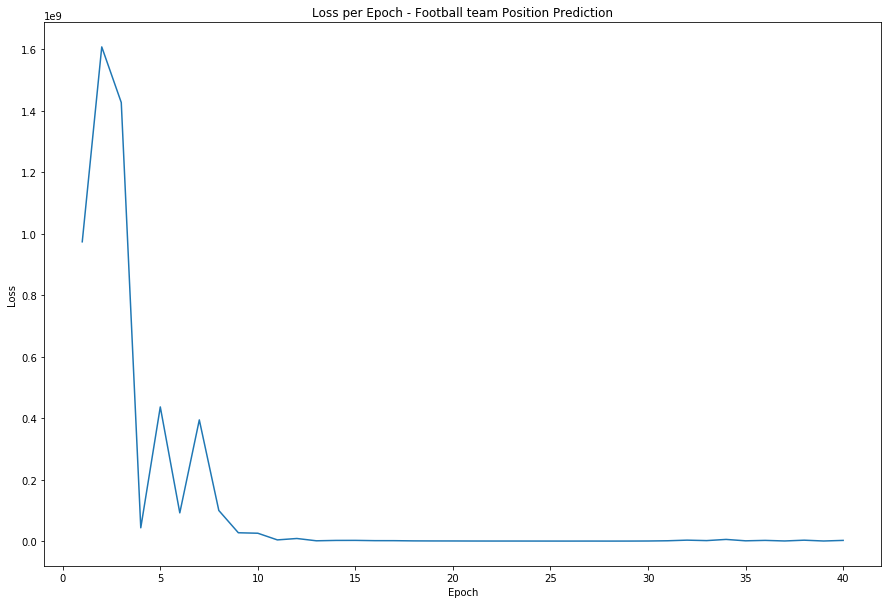

In [2]:
%%local
%matplotlib inline
import json
from hops import hdfs
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
results_path = hdfs.project_path() + "Logs/featurestore_tour_model_results_loss.txt"
results = json.loads(hdfs.load(results_path))
y = results["loss"] #loss
x = list(range(1, len(y)+1))#epoch
plt.title("Loss per Epoch - Football team Position Prediction")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x,y)